#### Importowanie modułów

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms, datasets
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Zbiory danych, modele, metody TL, hiperparametry

In [11]:
DATASETS = [
    'CIFAR10'
]
MODELS = [
    models.alexnet(pretrained=True),
    #models.vgg16(pretrained=True),
    #models.resnet50(pretrained=True)
]
TL_METHODS = [
    #'no_freezing',
    #'classic_tl',
    'fine_tuning'
]

# Hyperparmeters
EPOCHS = 1
BATCH_SIZE = 64

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Utworzenie Data setów i data loaderów

In [12]:
def create_datasets_and_dataloaders(dataset_name: str, model):

    if isinstance(model, models.AlexNet) or isinstance(model, models.VGG) or isinstance(model, models.ResNet):
        base_transforms = [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    else:
        base_transforms = [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]

    train_transform = transforms.Compose(base_transforms)
    test_transform = transforms.Compose(base_transforms)

    preprocessing = [
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(0.5),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
    ]

    train_transform.transforms.extend(preprocessing)

    if dataset_name == 'CIFAR10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
        print("Loaders created")

    return train_set, test_set, train_loader, test_loader

#### Przetwarzanie modeli do transfer learningu

In [13]:
def apply_transfer_learning(model, tl_method):
    if tl_method == 'classic_tl' or tl_method == 'fine_tuning':
        for param in model.parameters():
            param.requires_grad = False

        if isinstance(model, models.AlexNet) or isinstance(model, models.VGG):
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif isinstance(model, models.ResNet):
            for param in model.fc.parameters():
                param.requires_grad = True

    elif tl_method == 'no_freezing':
        for param in model.parameters():
            param.requires_grad = True


def customize_model(model, num_classes, tl_method):
    if isinstance(model, models.AlexNet):
        dropout = 0.5
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    elif isinstance(model, models.VGG):
        dropout = 0.5
        model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    elif isinstance(model, models.ResNet):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    print("Classifier for model has been changed.")
    apply_transfer_learning(model, tl_method)
    print("Transfer learning method:", tl_method, "applied.")

    return model

#### Funkcja mrożąca do naszej metody

In [14]:

def freeze_percentage(model, percentage):
    """Freeze a percentage of the model's parameters based on gradient norms."""
    grad_params = [(param.grad.norm(), param) for param in model.parameters() if param.requires_grad and param.grad is not None]
    grad_params.sort(key=lambda x: x[0])
    num_params_to_freeze = int(percentage * len(grad_params))

    for _, param in grad_params[:num_params_to_freeze]:
        param.requires_grad = False

#### Ustawienia fine-tuningu

In [15]:
def adjust_fine_tuning(model, optimizer):
    """Adjust the model and optimizer for fine-tuning."""
    for param in model.parameters():
        param.requires_grad = True
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.0001

#### Pętla treningowo walidacyjna

In [16]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using: {device}")

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs, tl_method):
    """Train and evaluate the model."""

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch + 1}") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                tepoch.set_postfix(loss=loss.item())

        train_accuracy = 100 * correct_train / total_train
        val_loss, val_accuracy = evaluate_model(model, test_loader, criterion, running_loss)

        history['train_loss'].append(running_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

    if tl_method == 'fine_tuning':
        adjust_fine_tuning(model, optimizer)
        print("Fine tuning applied. Learning rate: ", optimizer.param_groups[0]['lr'])
        tl_method = 'no_freezing'
        fine_tuning_history = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs, tl_method)
        history = {key: history[key] + fine_tuning_history[key] for key in history}


    return history


def evaluate_model(model, test_loader, criterion, running_loss):
    """Evaluate the model and adjust learning rate if fine-tuning."""
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Train Loss: {running_loss/len(train_loader)}, '
          f'Validation Loss: {val_loss/len(test_loader)}, '
          f'Accuracy: {100 * correct_val / total_val}%')

    return avg_val_loss, val_accuracy


# Main loop
learning_histories = []

for id_dataset, dataset in enumerate(DATASETS):
    print(f"Using the {dataset} dataset.")


    for id_tl_method, tl_method in enumerate(TL_METHODS):
        print(f"Using the {tl_method} method")

        for id_model, model in enumerate(MODELS):
            train_set, test_set, train_loader, test_loader = create_datasets_and_dataloaders(dataset, model=model)
            num_classes = len(train_set.classes)

            print(f"Using the {model.__class__.__name__} model")
            model = customize_model(model, num_classes, tl_method)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            model.to(device)

            print("Training starts")
            history = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, EPOCHS, tl_method)
            learning_histories.append(history)


Using: cuda
Using the CIFAR10 dataset.
Using the fine_tuning method
Files already downloaded and verified
Files already downloaded and verified
Loaders created
Using the AlexNet model
Classifier for model has been changed.
Transfer learning method: fine_tuning applied.
Training starts


Epoch 1: 100%|██████████| 782/782 [02:26<00:00,  5.35it/s, loss=0.51]


Train Loss: 0.9859659809361944, Validation Loss: 0.6758721041831242, Accuracy: 78.65%
Fine tuning applied. Learning rate:  0.0001


Epoch 1: 100%|██████████| 782/782 [02:54<00:00,  4.49it/s, loss=0.513]


Train Loss: 0.6119377607922725, Validation Loss: 0.5202642512169613, Accuracy: 83.97%


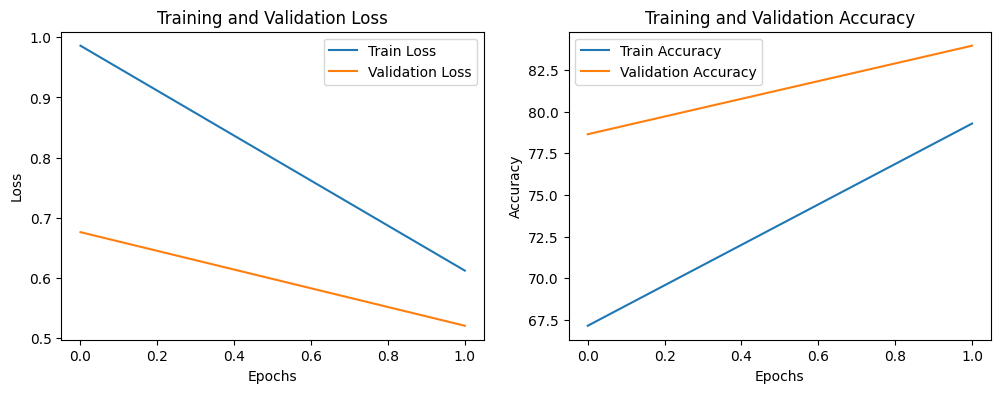

In [17]:
for history in learning_histories:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()